<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/tutorials/W2D1_Macrocircuits/student/W2D1_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W2D1_Macrocircuits/student/W2D1_Tutorial1.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 1: Depth vs Width

**Week 2, Day 1: Macrocircuits**

**By Neuromatch Academy**

__Content creators:__ Gabriel Mel de Fontenay

__Content reviewers:__ Hlib Solodzhuk

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk

<br>


___


# Tutorial Objectives

*Estimated timing of tutorial: 1 hour*

In this tutorial we will take a closer look at the expressivity of the networks by observing the following:

- The **universal approximator theorem** guarantees that we can approximate any complex function using a network with a single hidden layer. The catch is that the approximating network might need to be extremely *wide*.
- We will explore this issue by constructing a complex function and attempting to fit it with shallow networks of varying widths.
- To create this complex function, we'll build a random deep neural network. This is an example of the **student-teacher setting**, where we attempt to fit a known *teacher* function (the deep network) using a *student* model (the shallow/wide network).
- We will find that the deep teacher network can be either very easy or very hard to approximate, and that the difficulty level is related to a form of **chaos** in the network activities.

In [1]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

from IPython.display import IFrame
link_id = "utbe7"
print(f"If you want to download the slides: https://osf.io/download/{link_id}/")

If you want to download the slides: https://osf.io/download/utbe7/


---
# Setup



In [2]:
# @title Install and import feedback gadget

# !pip3 install vibecheck datatops --quiet

# from vibecheck import DatatopsContentReviewContainer
# def content_review(notebook_section: str):
#     return DatatopsContentReviewContainer(
#         "",  # No text prompt - leave this as is
#         notebook_section,
#         {
#             "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
#             "name": "sciencematch_sm", # change the name of the course : neuromatch_dl, climatematch_ct, etc
#             "user_key": "y1x3mpx5",
#         },
#     ).render()

# feedback_prefix = "W2D1_T1"

In [3]:
# Imports

#working with data
import numpy as np

#plotting
import matplotlib.pyplot as plt
import logging

#interactive display
import ipywidgets as widgets
from tqdm.notebook import tqdm as tqdm

#modeling
import torch
import torch.nn as nn

In [4]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [5]:
# @title Plotting functions

def plot_loss(Es):
    """
    Plot loss progression over time.

    Inputs:
    - Es (np.ndarray): sequence of loss values during training.
    """
    with plt.xkcd():
        plt.semilogy(Es_deep)
        plt.xlabel('Epochs')
        plt.ylabel('Error')
    plt.title("Loss")
    plt.show()

def plot_loss_as_function_of_width(Ws_student, Es_test, Es_train):
    """
    Plot final loss of training as the function of the width of the network.
    """
    with plt.xkcd():
        plt.loglog(Ws_student, Es_test, '.-')
        plt.loglog(Ws_student, Es_train[:,-1], '.-')
        plt.legend(['Test', 'Train'])
        plt.xlabel('Width')
        plt.ylabel('Error')
    plt.title("Loss")
    plt.show()

def plot_students_predictions_vs_teacher_values(Es_train, X_test, y_test):
    """
    Plot loss progression over the time and predicted values of student after training versus true ones generated from teacher.

    Inputs:
    - Es_train (np.ndarray): loss values.
    - X_test (np.ndarray): test input data.
    - y_test (np.ndarray): test outpu data.
    """
    with plt.xkcd():
        fig, axes = plt.subplots(1,2,figsize=(10,5))
        plt.locator_params(nbins=3)

        axes[0].semilogy(Es_train/float(y_test.var()))
        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('Error')

        axes[1].scatter(y_test.detach(),student(X_test).detach())
        axes[1].set_xlabel('Teacher')
        axes[1].set_ylabel('Student')

        axes[1].tick_params(axis='y', labelrotation=90)
        axes[1].set_yticks([-0.01,0,0.01])
        axes[1].set_xticks([-0.01,0,0.01])

In [6]:
# @title Set random seed

import random
import numpy as np

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(seed = 42)

---

# Section 1: Introduction

In this section we will create functions to capture the snippets of code that we will use repeatedly in what follows.

In [7]:
# @title Video 1: Introduction

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'fxbq5C0Us2U')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)


The [universal approximator theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem) (UAT) guarantees that we can approximate any function arbitrarily well using a shallow network - ie. a network with a single hidden layer. So why do we need depth? The "catch" in the UAT is that approximating a complex function with a shallow network can require a very large number of hidden units - ie. the network must be very wide.

To illustrate this fact, we'll create a complex function and then attempt to fit it with single-hidden-layer neural networks of different widths. What we'll find is that although the UAT guarantees that sufficiently wide networks can approximate our function, the performance will actually not be very good for our shallow nets of modest width.

One easy way to create a complex function is to build a random deep neural network. We then have a teacher network which generates the ground truth outputs, and a student network whose goal is to learn the mapping implemented by the teacher. This approach - unsurprisingly known as the student-teacher setting - is useful for both computational and mathematical study of neural networks, since it gives us complete control of the data generation process. Unlike with real world data, we know the exact distribution of inputs and correct outputs.

Finally, we will show that depending on the distribution of the weights, a random deep neural network can be either very difficult or very easy to approximate with a shallow network. The "complexity" of the function computed by random deep network thus depends crucially on the weight distribution. One can actually understand the boundary between hard and easy cases as a kind of boundary between chaos and non-chaos in a certain dynamical system. We will confirm that on the non-chaotic side, a random deep neural network can be effectively approximated by a shallow net. This demonstration will be based on ideas from the paper

[*Exponential expressivity in deep neural networks through transient chaos*](https://papers.nips.cc/paper_files/paper/2016/hash/148510031349642de5ca0c544f31b2ef-Abstract.html) Poole et al. Neurips (2016).

In [8]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_introduction")

## Coding Exercise 1: Create an MLP

In the code cell below complete missing parts of the function which takes in an input dimension, a layer width, and a number of layers, and creates a simple MLP in pytorch. In between each layer, we are going to insert a hyperbolic tangent nonlinearity layer (`nn.Tanh()`).

Convention: Because we will count the input as a layer, a depth of 2 will mean a network with just one hidden layer, followed by the output neuron. A depth of 3  will mean 2 hidden layers, and so on.

In [9]:
def make_MLP(n_in, W, D, nonlin='tanh'):
    """
    Create `nn.Sequnetial()` fully-connected model in pytorch with the given parameters.

    Inputs:
    - n_in (int): input dimension.
    - W (int): width of the network.
    - D (int): depth if the network.
    - nonlin (str, default = "tanh"): activation function to use.

    Outputs:
    - net (nn.Sequential): network.
    """

    ###################################################################
    ## Fill out the following then remove
    raise NotImplementedError("Student exercise: complete function which creates MLP with the given parameters.")
    ###################################################################

    #activation function
    if nonlin == 'tanh':
        nonlin = ...
    elif nonlin == 'relu':
        nonlin == nn.ReLU()
    else:
        assert(False)

    # Assemble D-1 hidden layers and one output layer

    #input layer
    layers = [nn.Linear(..., ..., bias = False), nonlin]
    for i in range(D - 2):
        #linear layer
        layers.append(nn.Linear(..., ..., bias = False))
        #activation function
        layers.append(...)
    #output layer
    layers.append(nn.Linear(..., ..., bias = False))

    return nn.Sequential(*...)

net = make_MLP(10, 3, 2)

NotImplementedError: Student exercise: complete function which creates MLP with the given parameters.

In [10]:
#to_remove solution
def make_MLP(n_in, W, D, nonlin='tanh'):
    """
    Create `nn.Sequnetial()` fully-connected model in pytorch with the given parameters.

    Inputs:
    - n_in (int): input dimension.
    - W (int): width of the network.
    - D (int): depth if the network.
    - nonlin (str, default = "tanh"): activation function to use.

    Outputs:
    - net (nn.Sequential): network.
    """

    #activation function
    if nonlin == 'tanh':
        nonlin = nn.Tanh()
    elif nonlin == 'relu':
        nonlin == nn.ReLU()
    else:
        assert(False)

    # Assemble D-1 hidden layers and one output layer

    #input layer
    layers = [nn.Linear(n_in, W, bias = False), nonlin]
    for i in range(D - 2):
        #linear layer
        layers.append(nn.Linear(W, W, bias = False))
        #activation function
        layers.append(nonlin)
    #output layer
    layers.append(nn.Linear(W, 1, bias = False))

    return nn.Sequential(*layers)

net = make_MLP(10, 3, 2)

Now, let us implement an auxiliary function which calculates the number of the parameters in the suggested MLP. Carefully think about the input, hidden and output layers.

In [11]:
def get_num_params(n_in,W,D):
    """
    Simple function to compute number of learned parameters in an MLP with given dimensions.

    Inputs:
    - n_in (int): input dimension.
    - W (int): width of the network.
    - D (int): depth if the network.

    Outputs:
    - num_params (int): number of parameters in the network.
    """
    ###################################################################
    ## Fill out the following then remove
    raise NotImplementedError("Student exercise: complete function which calculates the number of parameters in the defined architecture of MLP.")
    ###################################################################

    input_params = ... * ...
    hidden_layers_params = (...) * ...**2
    output_params = ...
    return input_params + hidden_layers_params + output_params

get_num_params(10, 3, 2)

NotImplementedError: Student exercise: complete function which calculates the number of parameters in the defined architecture of MLP.

In [12]:
#to_remove solution

def get_num_params(n_in,W,D):
    """
    Simple function to compute number of learned parameters in an MLP with given dimensions.

    Inputs:
    - n_in (int): input dimension.
    - W (int): width of the network.
    - D (int): depth if the network.

    Outputs:
    - num_params (int): number of parameters in the network.
    """
    input_params = n_in * W
    hidden_layers_params = (D-2) * W**2
    output_params = W
    return input_params + hidden_layers_params + output_params

get_num_params(10, 3, 2)

33

In [13]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_create_mlp")

## Coding Exercise 2: Initialize model weights

Write a function that, given a model and a $\sigma$, initializes all weights in the model according to a normal distribution with mean $0$ and standard deviation
 
 $$\frac{\sigma}{\sqrt{n_{in}}},$$
 where $n_{in}$ is the number of inputs to the layer.

In [14]:
set_seed(42)

def initialize_layers(net,sigma):
    """
    Set weight to each of the parameters in the model of value sigma/sqrt(n_in), where n_in is the number of inputs to the layer.

    Inputs:
    - net (nn.Sequential): network.
    - sigma (float): standard deviation.
    """
    ###################################################################
    ## Fill out the following then remove
    raise NotImplementedError("Student exercise: set initial values to the weights of MLP.")
    ###################################################################
    for param in ...:
        n_in = param.shape[1]
        nn.init.normal_(param, std = ...)

initialize_layers(net, 1)
next(net.parameters())[0][0]

NotImplementedError: Student exercise: set initial values to the weights of MLP.

In [15]:
# to_remove solution
set_seed(42)

def initialize_layers(net,sigma):
    """
    Set weight to each of the parameters in the model of value sigma/sqrt(n_in), where n_in is the number of inputs to the layer.

    Inputs:
    - net (nn.Sequential): network.
    - sigma (float): standard deviation.
    """
    for param in net.parameters():
        n_in = param.shape[1]
        nn.init.normal_(param, std = sigma/np.sqrt(n_in))

initialize_layers(net, 1)
next(net.parameters())[0][0]

tensor(0.6093, grad_fn=<SelectBackward0>)

In [16]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_initialize_model_weights")

## Coding Exercise 3: Generate a dataset

Given a network, generate the input data by sampling from a multivariate gaussian distribution, and output data by passing the inputs through the network. Don't forget to `.detach()` the outputs - otherwise gradients will be computed for these (with respect to the teacher weights, which we don't want).

In [17]:
set_seed(42)

def make_data(net, n_in, n_examples):
    """
    Generate data by sampling from a multivariate gaussian distribution, and output data by passing the inputs through the network.

    Inputs:
    - net (nn.Sequential): network.
    - n_in (int): input dimension.
    - n_examples (int): number of data examples to generate.

    Outputs:
    - X (torch.tensor): input data.
    - y (torch.tensor): output data.
    """
    ###################################################################
    ## Fill out the following then remove
    raise NotImplementedError("Student exercise: complete data generation.")
    ###################################################################
    X = torch.randn(..., ...)
    y = net(...).detach()
    return X, ...

X, y = make_data(net, 10, 10000000)
X[0][0]

NotImplementedError: Student exercise: complete data generation.

In [18]:
# to_remove solution
set_seed(42)

def make_data(net, n_in, n_examples):
    """
    Generate data by sampling from a multivariate gaussian distribution, and output data by passing the inputs through the network.

    Inputs:
    - net (nn.Sequential): network.
    - n_in (int): input dimension.
    - n_examples (int): number of data examples to generate.

    Outputs:
    - X (torch.tensor): input data.
    - y (torch.tensor): output data.
    """
    X = torch.randn(n_examples, n_in)
    y = net(X).detach()
    return X, y

X, y = make_data(net, 10, 10000000)
X[0][0]

tensor(1.9269)

In [19]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_generate_dataset")

## Coding Exercise 4: Train model and compute loss

In this coding exercise, write a function that will train a given net on a given dataset. Function parameters include the network, the training inputs and outputs, the number of steps and the learning rate. Set up loss function as MSE.

In [20]:
set_seed(42)

def train_model(net, X, y, n_epochs, lr, progressbar=True):
    """
    Perform training of the network.

    Inputs:
    - net (nn.Sequential): network.
    - X (torch.tensor): input data.
    - y (torch.tensor): output data.
    - n_epochs (int): number of epochs to train the model for.
    - lr (float): learning rate for optimizer (we will use `Adam` by default).
    - progressbar (bool, default = True): whether to use additional bar for displaying training progress.

    Outputs:
    - Es (np.ndarray): array which contains loss for each epoch.
    """
    ###################################################################
    ## Fill out the following then remove
    raise NotImplementedError("Student exercise: complete training of the network.")
    ###################################################################

    # Set up optimizer
    loss_fn = ...
    optimizer = torch.optim.Adam(..., lr = ...)

    # Run training loop
    Es = np.zeros(...)
    for n in (tqdm(range(n_epochs)) if progressbar else range(n_epochs)):
        y_pred = net(...)
        loss = loss_fn(..., y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        Es[n] = float(...)

    return Es

In [21]:
#to_remove solution

set_seed(42)

def train_model(net, X, y, n_epochs, lr, progressbar=True):
    """
    Perform training of the network.

    Inputs:
    - net (nn.Sequential): network.
    - X (torch.tensor): input data.
    - y (torch.tensor): output data.
    - n_epochs (int): number of epochs to train the model for.
    - lr (float): learning rate for optimizer (we will use `Adam` by default).
    - progressbar (bool, default = True): whether to use additional bar for displaying training progress.

    Outputs:
    - Es (np.ndarray): array which contains loss for each epoch.
    """

    # Set up optimizer
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)

    # Run training loop
    Es = np.zeros(n_epochs)
    for n in (tqdm(range(n_epochs)) if progressbar else range(n_epochs)):
        y_pred = net(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        Es[n] = float(loss.detach())

    return Es

Es = train_model(net, X, y, 10, 1e-3)
Es[0]

  0%|          | 0/10 [00:00<?, ?it/s]

0.0

### Coding Exercise 4 Discussion

1. Why do you think we obtain zero error right away (on the first epoch)?

In [22]:
#to_remove explanation

"""
Discussion: Why do you think we obtain zero error right away (on the first epoch)?

The deal is, the data is generated by the given network, thus there is no need to change weights at all, the gradients are zeros:)
""";

Now, write a helper function that computes the loss of a net on a dataset. It takes the following parameters: the network and the dataset inputs and outputs.

In [23]:
def compute_loss(net, X, y):
    """
    Calculate loss on given network and data.

    Inputs:
    - net (nn.Sequential): network.
    - X (torch.tensor): input data.
    - y (torch.tensor): output data.

    Outputs:
    - loss (float): computed loss.
    """
    ###################################################################
    ## Fill out the following then remove
    raise NotImplementedError("Student exercise: complete loss calculation.")
    ###################################################################
    loss_fn = ...

    y_pred = ...
    loss = loss_fn(..., ...)
    loss = float(...)
    return loss

loss = compute_loss(net, X, y)
loss

NotImplementedError: Student exercise: complete loss calculation.

In [24]:
#to_remove solution

def compute_loss(net, X, y):
    """
    Calculate loss on given network and data.

    Inputs:
    - net (nn.Sequential): network.
    - X (torch.tensor): input data.
    - y (torch.tensor): output data.

    Outputs:
    - loss (float): computed loss.
    """
    loss_fn = nn.MSELoss()

    y_pred = net(X)
    loss = loss_fn(y_pred, y)
    loss = float(loss.detach())
    return loss

loss = compute_loss(net, X, y)
loss

0.0

In [25]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_train_model_and_compute_loss")

---

# Section 2: Fitting a deep network with a shallow network

Estimated timing to here from start of tutorial: 20 minutes

We will now use the functions we've created to experiment with deep network fitting. In particular, we will see to what extent it is possible to fit a deep net using a shallow net. Specifically, we will fix a deep teacher and then fit it with a single-hidden-layer net with varying width. In principle, if the number of hidden units is large enough, the error should be low. Let's see!

In [26]:
# @title Video 2: Deep network fit with a shallow network

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'wbjvcINRBGs')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [27]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_deep_network_fit_with_a_shallow_network")

## Coding Exercise 5: Create learning problem

Create a "deep" teacher network that accepts inputs of size 5. Give the network a width of 5 and a depth of 5. Use this to generate both a training and test set with 4 thousands examples for training and 1 thousand for testing. Use a standard deviation of value 2.

In [28]:
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete set up.")
###################################################################
torch.manual_seed(-1)

# Create teacher
n_in = ...     # input dimension
W_teacher, D_teacher = ..., ...  # teacher width, depth
sigma_teacher = ...     # teacher weight variance
teacher = make_MLP(..., ..., ...)
initialize_layers(..., ...)

# generate train and test set
N_train, N_test = ..., ...
X_train, y_train = make_data(..., ..., ...)
X_test, y_test = make_data(..., ..., ...)

X_test[0][0]

NotImplementedError: Student exercise: complete set up.

In [29]:
#to_remove solution
torch.manual_seed(-1)

# Create teacher
n_in = 5     # input dimension
W_teacher, D_teacher = 5, 5  # teacher width, depth
sigma_teacher = 2     # teacher weight variance
teacher = make_MLP(n_in, W_teacher, D_teacher)
initialize_layers(teacher, sigma_teacher)

# generate train and test set
N_train, N_test = 4000, 1000
X_train, y_train = make_data(teacher, n_in, N_train)
X_test, y_test = make_data(teacher, n_in, N_test)

X_test[0][0]

tensor(0.1908)

### Coding Exercise 5 Discussion

1. What is the minimum error achievable on the generated problem with an MLP?
2. What is the minimum error achievable with a 1-hidden-layer MLP?

In [30]:
#to_remove explanation

"""
Discussion: 1. What is the minimum error achievable on the generated problem with an MLP?
2. What is the minimum error achievable with a 1-hidden-layer MLP?

1. This is a trick question! We generated the data ourselves; the teacher network is an MLP. In principle, a student network with the same architecture could learn the exact weights of the teacher and achieve exactly 0 error.
2. By the universal approximator theorem, we can approximate the teacher network arbitrarily well with a 1-hidden-layer MLP, as long as there is not limit on the number of hidden units. So the answer is technically 0. In practice, however, when fitting a complex function, for example a deep teacher network, the number of hidden units required for low error can be totally impractical.
""";

In [31]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_create_learning_problem")

## Coding Exercise 6: Train net with same architecture

Create a student network with the same achitecture as the teacher network - that is, the same width and depth. Train it and confirm that a network with the same architecture can indeed achieve low test error. You may need to train for a large number of iterations, and you may need to adjust the learning rate as learning proceeds.

At first, let us confirm that the number of training examples is greater than three times number of the parameters (so we have enough of data).

In [32]:
n_in = 5
W_student, D_student = 5, 5
student = make_MLP(n_in, W_student, D_student)

# make sure we have enough data
P = get_num_params(n_in, W_student, D_student)
assert(N_train > 3*P)

Now, let's train the student and observe the loss on semi-log plot (y-axis is logarithmic)! Your task is to complete missing parts of the code. While it's training, you can go to the next coding exercise and return back to observe the results (it will take approximately 4 minutes).

In [33]:
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: train student on the generated data from teacher.")
###################################################################
lr = 0.003
Es_deep = []
for i in range(4):
    Es_deep.append(train_model(..., ..., ..., 50000, ...))
    #observe we reduce learning rate
    lr /= 3
Es_deep = np.array(Es_deep)
Es_deep = Es_deep.ravel()

# evaluate test error
loss_deep = compute_loss(..., ..., ...) / float(y_test.var())
print("Loss of deep student: ",loss_deep)
plot_loss(Es_deep)

NotImplementedError: Student exercise: train student on the generated data from teacher.

In [34]:
#to_remove solution
lr = 0.003
Es_deep = []
for i in range(4):
    Es_deep.append(train_model(student, X_train, y_train, 50000, lr))
    #observe we reduce learning rate
    lr /= 3
Es_deep = np.array(Es_deep)
Es_deep = Es_deep.ravel()

# evaluate test error
loss_deep = compute_loss(student, X_test, y_test) / float(y_test.var())
print("Loss of deep student: ",loss_deep)
plot_loss(Es_deep)

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_train_net_with_the_same_architecture")

## Coding Exercise 7: Train 2 layer net with varying width

Let us now try to fit the deep teacher network with a shallow student network. Let's give the student a single hidden layer, and let's study the error as a function of the student width $W_s$. For a range of widths between, say, 5 and 200, create a student network, train it on the training set, and compute its test error. The training time will take approximately 2 minutes.

Then, plot the training and testing errors as a function of width on a log-log plot. How does the error of the shallow network compare to that of the deep network? 

In [ ]:
D_student = 2  # student depth
Ws_student = np.array([5, 15, 45, 135]) # widths

lr = 1e-3
n_epochs = 20000
Es_shallow_train = np.zeros((len(Ws_student), n_epochs))
Es_shallow_test = np.zeros(len(Ws_student))

###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: train different students on the already generated data from teacher.")
###################################################################

for index, W_student in enumerate(tqdm(Ws_student)):

    student = make_MLP(..., ..., ...)

    # make sure we have enough data
    P = get_num_params(n_in, W_student, D_student)
    assert(N_train > 3*P)

    # train
    Es_shallow_train[index] = train_model(..., ..., ..., ..., lr, progressbar=False)
    Es_shallow_train[index] /= y_test.var()

    # evaluate test error
    loss = compute_loss(..., ..., ...)/y_test.var()
    Es_shallow_test[index] = ...

plot_loss_as_function_of_width(Ws_student, Es_shallow_test, Es_shallow_train)

  0%|          | 0/4 [00:00<?, ?it/s]

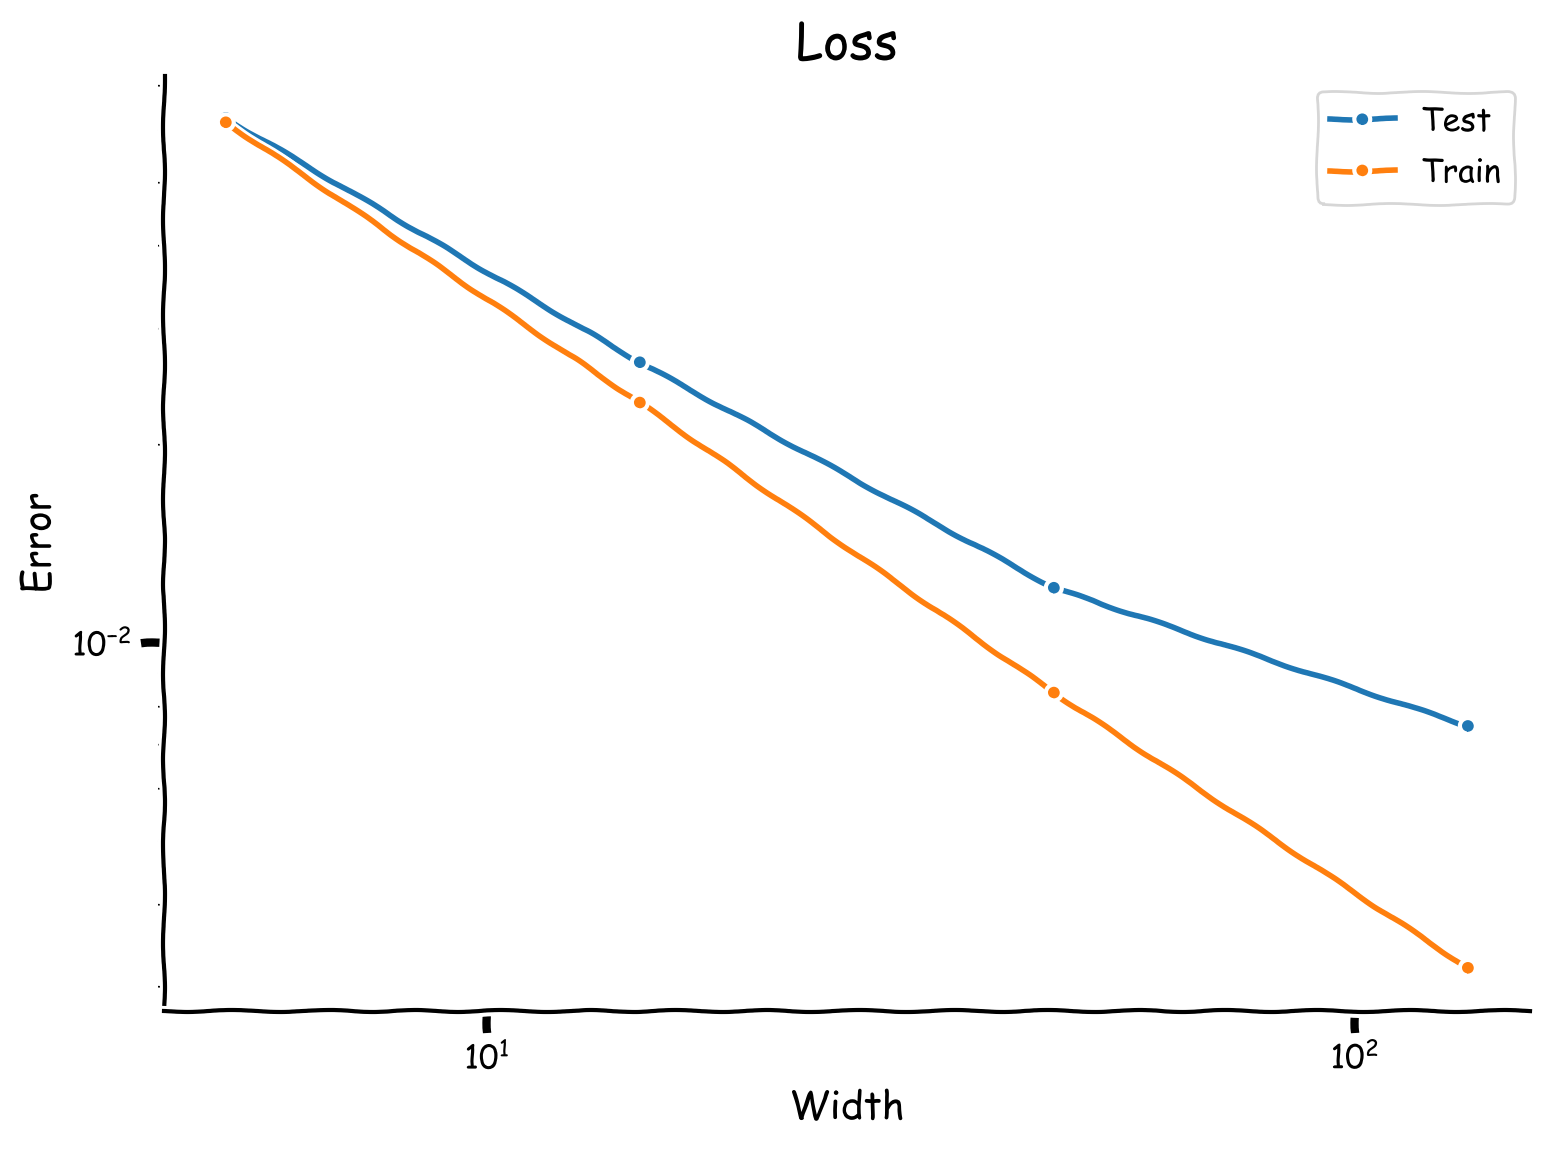

In [35]:
#to_remove solution
D_student = 2  # student depth
Ws_student = np.array([5, 15, 45, 135]) # widths

lr = 1e-3
n_epochs = 20000
Es_shallow_train = np.zeros((len(Ws_student), n_epochs))
Es_shallow_test = np.zeros(len(Ws_student))


for index, W_student in enumerate(tqdm(Ws_student)):

    student = make_MLP(n_in, W_student, D_student)

    # make sure we have enough data
    P = get_num_params(n_in, W_student, D_student)
    assert(N_train > 3*P)

    # train
    Es_shallow_train[index] = train_model(student, X_train, y_train, n_epochs, lr, progressbar=False)
    Es_shallow_train[index] /= y_test.var()

    # evaluate test error
    loss = compute_loss(student, X_test, y_test)/y_test.var()
    Es_shallow_test[index] = loss

plot_loss_as_function_of_width(Ws_student, Es_shallow_test, Es_shallow_train)

In [36]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_train_two_layer_net_with_varying_width")

## Coding Exercise 8: Network size prediction

Let's suppose that the test error will continue to improve with increasing width according to the same trend in the previous plot - which is probably too optimistic, but will let us do some back-of-the-envelope calculations. Specifically, let us a assume there is a linear relationship

$$ \log E=m \log W+b$$
between the log of the width and the log of the error. Fit this linear model from our experiment and use it to predict the number of hidden units needed to achieve a relative error of, say, $10^{-6}$.

In [ ]:
error_target = 1e-6

###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: fit linear model and predict the number of hidden units.")
###################################################################

m,b = np.polyfit(np.log(...), np.log(...), 1)
print('Predicted width: ',np.exp((np.log(...) - ...) / ...))

In [37]:
# to_remove solution
error_target = 1e-6

m,b = np.polyfit(np.log(Ws_student), np.log(Es_shallow_test), 1)
print('Predicted width: ',np.exp((np.log(error_target) - b) / m))

Predicted width:  99104392.33778252


In [38]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_network_size_prediction")

---

# Section 3: Deep networks in the quasilinear regime

Estimated timing to here from start of tutorial: 45 minutes

We've just shown that certain deep networks are difficult to fit. In this section we will talk about regimes in which we'd expect a shallow network to be able to approximate a deep teacher relatively well.

In [39]:
# @title Video 3: Deep networks in the quasilinear regime

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'X1Q-LC2Skwk')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [40]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_deep_networks_in_the_quasilinear_regime")

One of the reasons that shallow nets cannot fit deep nets in general is that random deep nets, in certain regimes, behave like chaotic systems: each layer can be thought of as a single step of a dynamical system, and the number of layers plays the role of the number of time steps. A deep network therefore effictively subjects its input to long-time chaotic dynamics which are, almost by definition, very difficult to predict accurately. In particular, *shallow* nets simply cannot capture the complex mapping implemented by deeper networks without resorting to an astronomical number of hidden units.

However, in other regimes, for example when the weights of the teacher network are small, the dynamics implemented by the teacher network are no longer chaotic. In fact, for small enough weights, they are nearly linear. In this regime, we'd expect a shallow network to be able to approximate a deep teacher relatively well.

For more on these ideas, see the paper

[*Exponential expressivity in deep neural networks through transient chaos*](https://papers.nips.cc/paper_files/paper/2016/hash/148510031349642de5ca0c544f31b2ef-Abstract.html) Poole et al. Neurips (2016).

To test this idea, we'll repeat the exercise above, this time initializing the teacher weights with a small $\sigma$, say, $0.4$, so that the teacher network is quasi-linear.

## Coding Exercise 9: Create dataset & Train a student network

Create training and test sets. Initialize the teacher network with $\sigma_{t} = 0.4$.

In [ ]:
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete set up.")
###################################################################
torch.manual_seed(-1)

# Create teacher
n_in = 5     # input dimension
W_teacher, D_teacher = 5, 5  # teacher width, depth
sigma_teacher = ...     # teacher weight variance
teacher = make_MLP(..., ..., ...)
initialize_layers(..., ...)

# generate train and test set
N_train, N_test = 4000, 1000
X_train, y_train = make_data(..., ..., ...)
X_test, y_test = make_data(..., ..., ...)

In [41]:
#to_remove solution
torch.manual_seed(-1)

# Create teacher
n_in = 5     # input dimension
W_teacher, D_teacher = 5, 5  # teacher width, depth
sigma_teacher = 0.4     # teacher weight variance
teacher = make_MLP(n_in, W_teacher, D_teacher)
initialize_layers(teacher, sigma_teacher)

# generate train and test set
N_train, N_test = 4000, 1000
X_train, y_train = make_data(teacher, n_in, N_train)
X_test, y_test = make_data(teacher, n_in, N_test)

Give the student network a single hidden layer with $10$ units. Train it for a similar amount of time as before. Determine the relative MSE.

In [ ]:
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: train student on the generated data from special teacher.")
###################################################################

W_student, D_student = ..., ...  # student width, depth

lr = 1e-3
n_epochs = 20000
Es_shallow_train = np.zeros((len(Ws_student),n_epochs))
Es_shallow_test = np.zeros(len(Ws_student))

student = make_MLP(..., ..., ...)
initialize_layers(student, sigma_teacher)

# make sure we have enough data
P = get_num_params(n_in, W_student, D_student)
assert(N_train > 3*P)

# train
Es_shallow_train = train_model(..., ..., ..., n_epochs, lr, progressbar=True)

# # evaluate test error
Es_shallow_test = compute_loss(..., ..., ...)/float(y_test.var())
print('Shallow student loss: ',Es_shallow_test)
plot_students_predictions_vs_teacher_values(Es_shallow_train, X_test, y_test)

  0%|          | 0/20000 [00:00<?, ?it/s]

Shallow student loss:  3.6418529073962724e-05


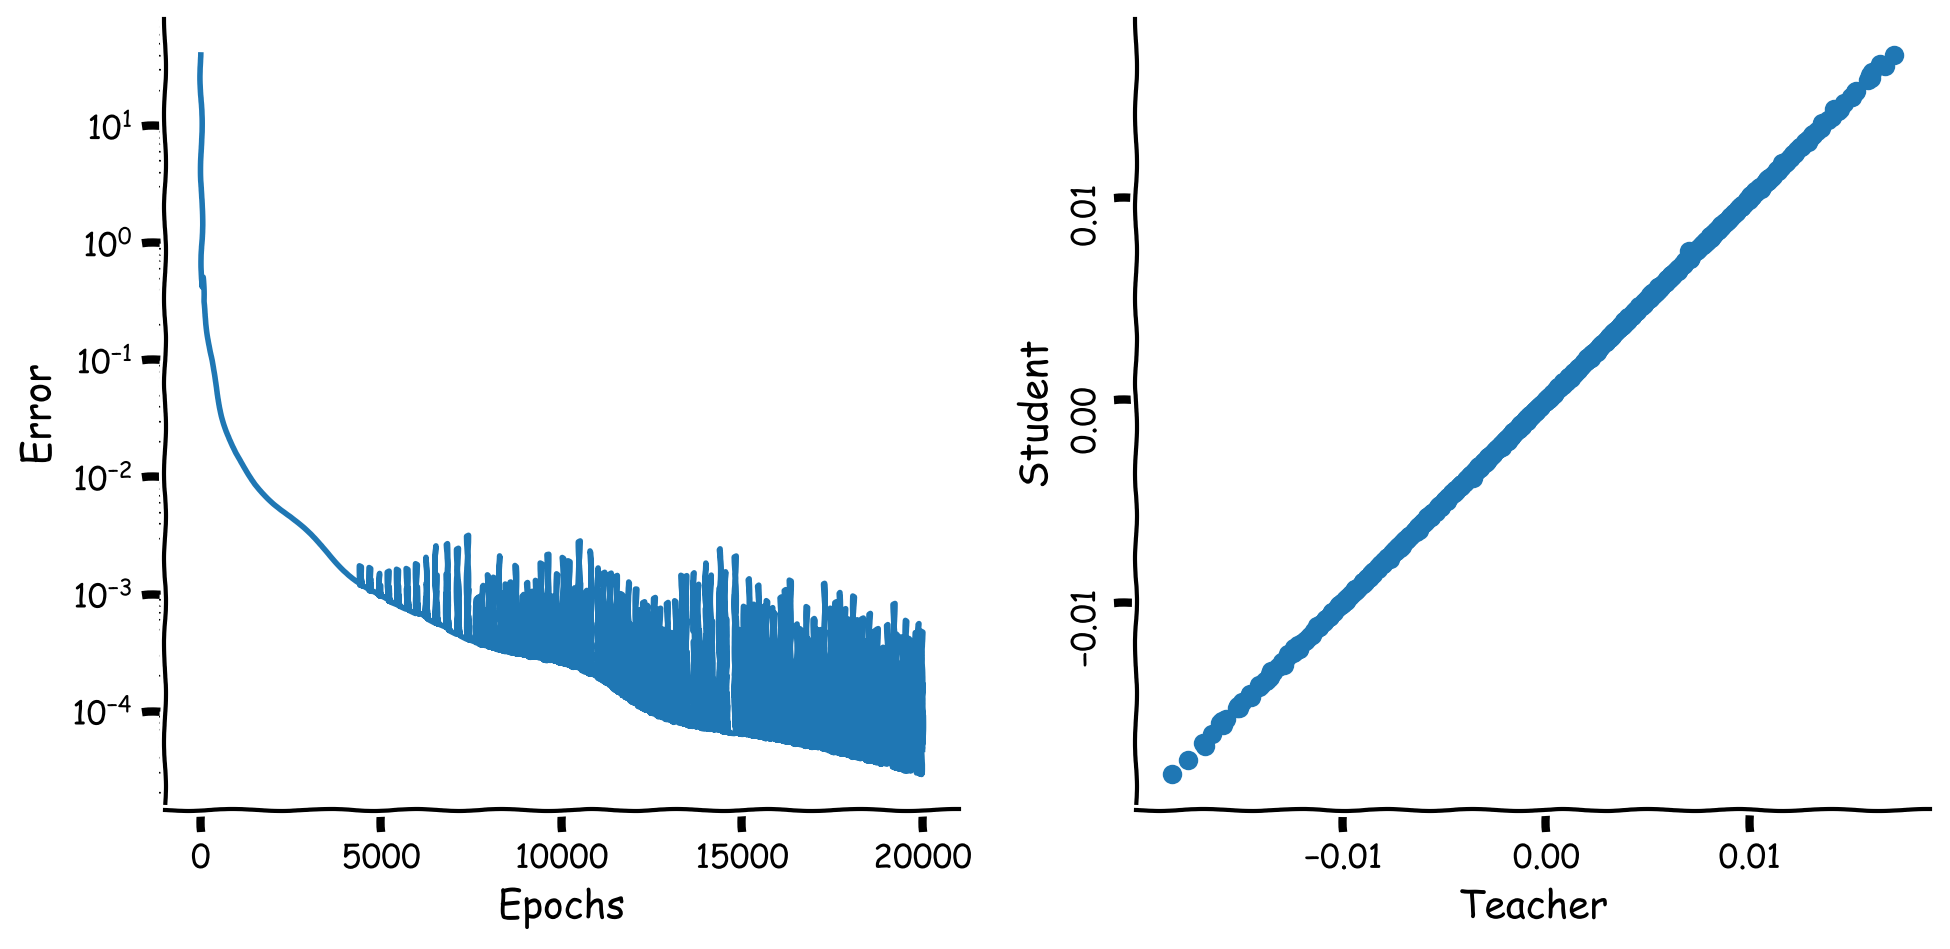

In [42]:
#to_remove solution
W_student, D_student = 10, 2  # student width, depth

lr = 1e-3
n_epochs = 20000
Es_shallow_train = np.zeros((len(Ws_student),n_epochs))
Es_shallow_test = np.zeros(len(Ws_student))

student = make_MLP(n_in, W_student, D_student)
initialize_layers(student, sigma_teacher)

# make sure we have enough data
P = get_num_params(n_in, W_student, D_student)
assert(N_train > 3*P)

# train
Es_shallow_train = train_model(student, X_train, y_train, n_epochs, lr, progressbar=True)

# # evaluate test error
Es_shallow_test = compute_loss(student, X_test, y_test)/float(y_test.var())
print('Shallow student loss: ',Es_shallow_test)
plot_students_predictions_vs_teacher_values(Es_shallow_train, X_test, y_test)

---
# Summary

*Estimated timing of tutorial: 1 hour*

In this tutorial:
- We discussed the **universal approximator theorem**, which guarantees that we can approximate any complex function using a network with a single hidden layer.
- To test this idea, we built a deep *teacher* network and attempted to fit it with a shallow *student* network.
- We found that achieving good performance requires a very wide network - i.e. a very large number of hidden units.
- We found that if the teacher network is initialized with very small weights, fitting becomes very easy.
- We discussed how the fitting difficulty is related to whether the teacher is initialized in the **chaotic** regime.
